In [1]:
import pandas as pd
import numpy as np
import datetime
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
US_BUSINESS_DAY = CustomBusinessDay(calendar=USFederalHolidayCalendar())
from sklearn.neighbors import KNeighborsClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore")

Data Loading and Cleaning

In [3]:
def process_data():
    ## quaterly data, already the gdp growth forecast
    #gdpNow = pd.read_csv('./data/GDPNOW_2011_2022.csv').rename(
    #        columns = {'DATE':'date','GDPNOW':'gdp now'}
    #        )
    #gdpNow['date'] = pd.to_datetime(gdpNow['date'])
    #gdpNow.sort_values('date',inplace=True)

    gdp = pd.read_excel('./data/GDPC1.xls',skiprows=10)
    gdp.columns = ['date','gdp']
    gdp['date'] = pd.to_datetime(gdp['date'])
    gdp.sort_values('date',inplace=True)
    gdp['gdp growth'] = gdp['gdp'].pct_change(4)
    del gdp['gdp']

    ## monthly spotprice
    InflationRate = pd.read_csv('./data/1yrExpectedInflationRate.csv').rename(
    columns={'DATE':'date','EXPINF1YR':'IR'})
    InflationRate['date'] = pd.to_datetime(InflationRate['date'])
    InflationRate.sort_values('date',inplace=True)
    InflationRate['IR_y2y_ratio'] = InflationRate['IR'].pct_change(12)

    CPI = pd.read_csv('./data/cpi.csv').rename(columns={'DATE':'date','CPIAUCSL':'CPI'})
    CPI['date'] = pd.to_datetime(CPI['date'])
    CPI.sort_values('date',inplace=True)
    CPI['CPI_y2y_ratio'] = CPI['CPI'].pct_change(12)

    pmi = pd.read_csv('./data/ISM-MAN_PMI.csv').sort_values('Date').rename(
            columns = {'Date':'date','PMI':'PMI'}
        )
    pmi['date'] = pd.to_datetime(pmi['date'])
    pmi.sort_values('date',inplace=True)
    pmi['pmi_y2y_ratio'] = pmi['PMI'].pct_change(12)

    ## weekly data
    nfci = pd.read_csv('./data/NFCI_1971_2022.csv').rename(
            columns = {'DATE':'date','NFCI':'NFCI'}
        )
    nfci['date'] = pd.to_datetime(nfci['date'])
    nfci.sort_values('date',inplace=True)

    Inventory = pd.read_csv('./data/Inventory.csv',skiprows=4).rename(
    columns = {
        'Week of':'date','Weekly U.S. Ending Stocks of Crude Oil and Petroleum Products Thousand Barrels':'Inventory'})
    Inventory['date'] = pd.to_datetime(Inventory['date'])
    Inventory.sort_values('date',inplace=True)
    Inventory['Inventory_y2y_ratio'] = Inventory['Inventory'].pct_change(12)
    Inventory['Inventory_mom_3_12'] = Inventory['Inventory'].rolling(3).mean() - Inventory['Inventory'].rolling(12).mean() 
    ## daily data
    USDIndex = pd.read_csv('./data/usd_index.csv')[['Date','Adj Close']].rename(
        columns = {'Date':'date','Adj Close':'USD'}
    )
    USDIndex['date'] = pd.to_datetime(USDIndex['date'])
    USDIndex.sort_values('date',inplace=True)
    USDIndex.dropna(inplace=True)
    USDIndex['usd_mom_20_125'] = USDIndex['USD'].rolling(20).mean() - USDIndex['USD'].rolling(125).mean()

    VIX = pd.read_csv('./data/VIX.csv').rename(
                columns = {'DATE':'date','VIXCLS':'VIX'}
            )
    VIX.drop(VIX[VIX['VIX'] == '.'].index, inplace=True)
    VIX['date'] = pd.to_datetime(VIX['date'])
    VIX['VIX'] = pd.to_numeric(VIX['VIX'])
    VIX.sort_values('date',inplace=True)

    wti = pd.read_excel('./data/PET_PRI_FUT_S1_D.xls', sheet_name=1,skiprows=2)
    wti.columns = ['date','F1','F2','F3','F4']
    wti['date'] = pd.to_datetime(wti['date'])
    wti = wti[wti['date']>=pd.Timestamp('20051201')]
    wti.sort_values('date',inplace=True)
    wti['dollar_ret'] = wti['F1'].diff()
    wti['dollar_vol_monthly'] = wti['dollar_ret'].rolling(20).std() * np.sqrt(252/20)
    wti['carry'] = wti['F1'] - wti['F4']
    wti['carry_mom_1_5'] = wti['carry'] - wti['carry'].rolling(5).mean()
    wti['carry_mom_5_20'] = wti['carry'].rolling(5).mean() - wti['carry'].rolling(20).mean()
    wti['carry_mom_20_125'] = wti['carry'].rolling(20).mean() - wti['carry'].rolling(125).mean()

    spotprice = pd.read_excel('./data/WTIprice.xls',skiprows=10)
    spotprice.columns = ['date','F1']
    spotprice['date'] = pd.to_datetime(spotprice['date'])
    spotprice.sort_values('date',inplace=True)
    spotprice['mom_1_5'] = spotprice['F1'] - spotprice['F1'].rolling(5,closed = 'both').mean()
    spotprice['mom_5_20'] = spotprice['F1'].rolling(5,closed = 'both').mean() - spotprice['F1'].rolling(20,closed = 'both').mean()
    spotprice['mom_20_250'] = spotprice['F1'].rolling(20,closed = 'both').mean() - spotprice['F1'].rolling(250,closed = 'both').mean()
    del spotprice['F1']
    ## merge data
    monthy_data = InflationRate.merge(CPI, how='outer').merge(pmi, how='outer')\
                .sort_values('date')
    #monthy_data = monthy_data[monthy_data['date']>=pd.Timestamp('20051201')]
    monthy_data.set_index('date',inplace=True)

    weekly_data = nfci.merge(Inventory, how='outer')\
                .sort_values('date')
    #weekly_data = weekly_data[weekly_data['date']>=pd.Timestamp('20051201')]
    weekly_data.set_index('date',inplace=True)

    daily_data = USDIndex.merge(wti,how='outer').merge(VIX, how='outer').merge(spotprice,how='outer').sort_values('date')
    #daily_data = daily_data[daily_data['date']>=pd.Timestamp('20051201')]
    daily_data.set_index('date',inplace=True)

    quaterly_data = gdp.sort_values('date')
    #quaterly_data = quaterly_data[quaterly_data['date']>=pd.Timestamp('20051201')]
    quaterly_data.set_index('date',inplace = True)

    ## forward data filling
    data = pd.concat([quaterly_data,monthy_data,
                             weekly_data,daily_data],axis=1)
    data.dropna(how='all', inplace=True)
    data.fillna(method='ffill', inplace=True)
    data.dropna(how='all',axis=0, subset = ['F1','F2','F3','F4'], inplace = True)
    data = data[data.index>=pd.Timestamp('20051201')]
    #data = data[[i for i in data.columns if not i in ['CPI','F1','F2','F3','F4','Inventory']]]
    return data

In [4]:
data = process_data()
data = data.dropna(how='any')

In [5]:
## we train the model with data before 20140101
data_test = data[data.index>pd.Timestamp('20140101')]
data_train = data[data.index<=pd.Timestamp('20140101')]

Feature selection

Part I: Macro features excluded (but with some technical signal constructed from macro signal, e.g. USD momentum, Inventory momentum, etc.)

In [6]:
features_name_macro_exluded = [i for i in data.columns if not i in ['F1','F2','F3','F4','Inventory',
                'PMI','NFCI','CPI','IR','gdp growth','USD']]

In [7]:
from Sparse_jump import *
from sklearn.preprocessing import StandardScaler

In [8]:
data_selected = data_train[features_name_macro_exluded]

Here we can see the differnet feature weights.

<AxesSubplot:>

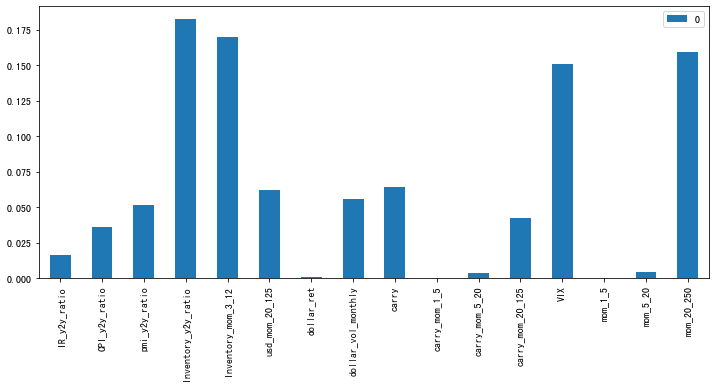

In [9]:
scaler = StandardScaler()
dt = scaler.fit_transform(data_selected)
states, feature_weights = sparse_jump(dt, n_states=3, max_features=20,jump_penalty=1)
pd.DataFrame(feature_weights/sum(feature_weights), index = data_selected.columns).plot(kind='bar', figsize=(12,5))

In [10]:
data_selected['states'] = states

In [11]:
# we want to see the summary statistics of different states, w.r.t different states
# states are ordered by mom_20_250 signal
important_features = data_selected.columns[np.where(feature_weights>=0.025)]
summary_table_macro_excluded = data_selected[important_features.to_list()+['states']].groupby('states').mean()\
                                .sort_values('mom_20_250').T

In [12]:
# we make an order for the states, bull +1, bear -1, static 0
print('original states(ordered by mom_20_250 signal) is: {}'.format(summary_table_macro_excluded.columns.tolist()))
print('The meaningful states should be: [-1, 0, 1]')
states_map = dict(zip(summary_table_macro_excluded.columns.tolist(), [-1,0,1]))
print(states_map)
data_selected['True_state'] = data_selected['states'].apply(lambda x: states_map[x])

original states(ordered by mom_20_250 signal) is: [1, 2, 0]
The meaningful states should be: [-1, 0, 1]
{1: -1, 2: 0, 0: 1}


In [13]:
summary_table_macro_excluded = data_selected[important_features.to_list()+['True_state']].groupby('True_state').mean().T
print(summary_table_macro_excluded)

True_state                     -1             0             1
IR_y2y_ratio            -0.744049     -0.050112      0.179381
CPI_y2y_ratio            0.003832      0.020395      0.025216
pmi_y2y_ratio           -0.260862      0.005271      0.060117
Inventory_y2y_ratio      0.018848      0.017719     -0.013564
Inventory_mom_3_12   13668.365054  12341.402165 -10062.374396
usd_mom_20_125           3.665166     -0.224478     -0.777604
dollar_vol_monthly      10.307824      5.267956      5.816277
carry                   -5.271290     -1.512623     -0.841729
carry_mom_20_125        -1.984615      0.313782      0.209834
VIX                     49.308903     19.836507     19.903681
mom_20_250             -41.975539      4.201011      6.906271


In [14]:
#features = data_selected[important_features.to_list()+['carry_mom_1_5','carry_mom_5_20','mom_1_5','mom_5_20']]
#features.to_hdf('./features/features_data.h5','abc')
features = data_selected[important_features.to_list()]
features.to_hdf('./features/features_data.h5','abc')
pd.to_pickle(feature_weights[np.where(feature_weights>=0.025)],'./features/features_weights')

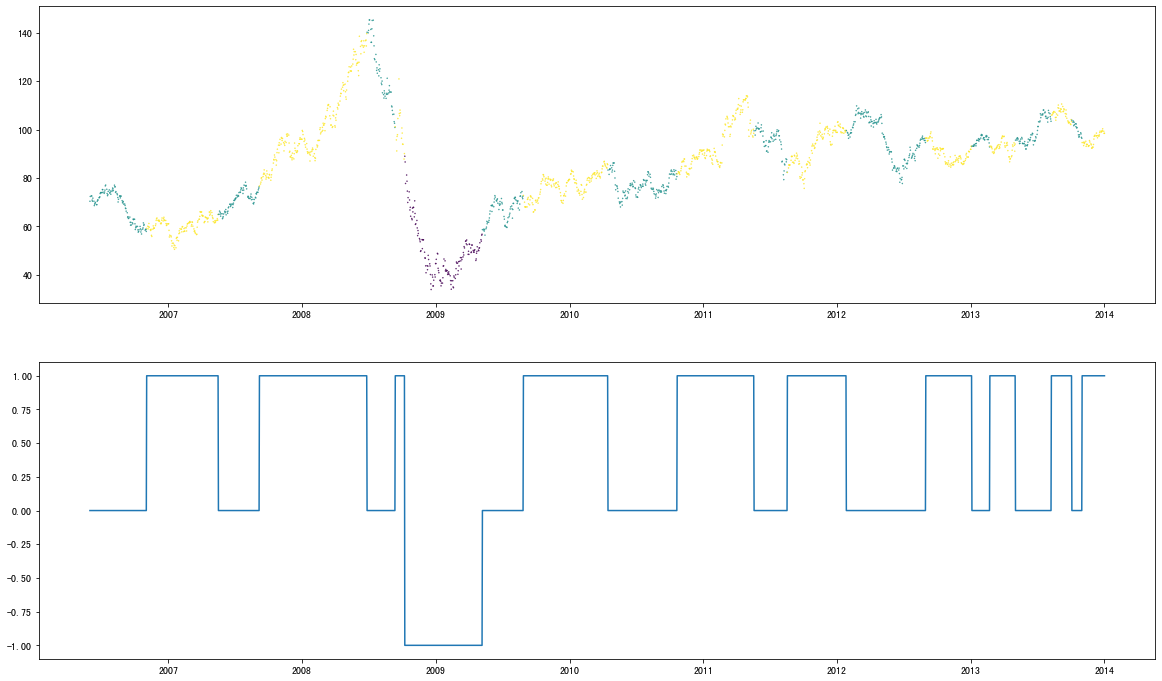

In [15]:
fig, axes = plt.subplots(ncols=1,nrows=2, sharex=False,figsize=(20,12))
axes[0].scatter(data_train.index.to_list(),data_train['F1'],c=data_selected['True_state'].values, s = 0.2)
axes[1].plot(data_train.index.to_list(),data_selected['True_state'].values)

KNN model state classification and prediction

In [16]:
# standardize the training data, use the previously fitted scaler to transform test data
X_train = scaler.fit_transform(data_selected[features_name_macro_exluded])
X_test = scaler.transform(data_test[features_name_macro_exluded])
y_train = data_selected['True_state'].values

In [17]:
# knn for state prediction
knn = KNeighborsClassifier(n_neighbors=20,weights='uniform')
knn_model = knn.fit(X_train,y_train)

In [18]:
pred = knn_model.predict(X_test)

In [19]:
data_test['s'] = pred

signal backtest

In [20]:
wti_data = pd.read_excel('./data/PET_PRI_FUT_S1_D.xls', sheet_name=1,skiprows=2)
exp_date = pd.read_excel('./data/Expiry Calendar HW1.xlsx')

In [21]:
from TradingTools.TradingFunc import *

In [22]:
wti_data = processing_data(wti_data,type = 'WTI')
wti_PL = get_everyday_position(wti_data.copy(), exp_date, type='WTI',consider_transaction=False)

In [23]:
wti_daily_PL = wti_PL[['Date','dF']]
wti_daily_PL.columns = ['Date','daily_PL']
wti_daily_PL.set_index('Date',inplace=True)

In [24]:
signal = data_test['s'].reset_index()
signal.columns = ['Date','signal']
signal.set_index('Date',inplace=True)

In [25]:
PL_signal = pd.concat([signal, wti_daily_PL],axis=1)
PL_signal.dropna(how='any',inplace=True)

In [26]:
# if market state is 0, -1, signal is -1, short the futures
# if market state is 1, signal is 1, long the future
PL_signal['signal'] = PL_signal['signal'].apply(lambda x: x if x>0 else -1)

In [27]:
# backtest
knn_jump_result = trading_strategy_backtest(PL_signal['daily_PL'], PL_signal['signal'])

In [28]:
carry_mom_20_125_signal = data_test['carry_mom_20_125'].apply(lambda x: 1 if x > 0 else -1).reset_index()
carry_mom_20_125_signal.columns = ['Date','signal']
carry_mom_20_125_signal.set_index('Date',inplace=True)
PL_carry_mom = pd.concat([carry_mom_20_125_signal, wti_daily_PL],axis=1)
PL_carry_mom.dropna(how='any',inplace=True)

carry_mom_20_125_result = trading_strategy_backtest(PL_carry_mom['daily_PL'], PL_carry_mom['signal'])

In [29]:
carry_mom_5_20_signal = data_test['carry_mom_5_20'].apply(lambda x: 1 if x > 0 else -1).reset_index()
carry_mom_5_20_signal.columns = ['Date','signal']
carry_mom_5_20_signal.set_index('Date',inplace=True)
PL_carry_mom = pd.concat([carry_mom_5_20_signal, wti_daily_PL],axis=1)
PL_carry_mom.dropna(how='any',inplace=True)

carry_mom_5_20_result = trading_strategy_backtest(PL_carry_mom['daily_PL'], PL_carry_mom['signal'])

In [30]:
carry_mom_1_5_signal = data_test['carry_mom_1_5'].apply(lambda x: 1 if x > 0 else -1).reset_index()
carry_mom_1_5_signal.columns = ['Date','signal']
carry_mom_1_5_signal.set_index('Date',inplace=True)
PL_carry_mom = pd.concat([carry_mom_1_5_signal, wti_daily_PL],axis=1)
PL_carry_mom.dropna(how='any',inplace=True)

carry_mom_1_5_result = trading_strategy_backtest(PL_carry_mom['daily_PL'], PL_carry_mom['signal'])

In [31]:
mom_1_5_signal = data_test['mom_1_5'].apply(lambda x: 1 if x > 0 else -1).reset_index()
mom_1_5_signal.columns = ['Date','signal']
mom_1_5_signal.set_index('Date',inplace=True)
PL_mom = pd.concat([mom_1_5_signal, wti_daily_PL],axis=1)
PL_mom.dropna(how='any',inplace=True)

mom_1_5_result = trading_strategy_backtest(PL_mom['daily_PL'], PL_mom['signal'])

In [32]:
mom_5_20_signal = data_test['mom_5_20'].apply(lambda x: 1 if x > 0 else -1).reset_index()
mom_5_20_signal.columns = ['Date','signal']
mom_5_20_signal.set_index('Date',inplace=True)
PL_mom = pd.concat([mom_5_20_signal, wti_daily_PL],axis=1)
PL_mom.dropna(how='any',inplace=True)

mom_5_20_result = trading_strategy_backtest(PL_mom['daily_PL'], PL_mom['signal'])

In [33]:
mom_20_250_signal = data_test['mom_20_250'].apply(lambda x: 1 if x > 0 else -1).reset_index()
mom_20_250_signal.columns = ['Date','signal']
mom_20_250_signal.set_index('Date',inplace=True)
PL_mom = pd.concat([mom_20_250_signal, wti_daily_PL],axis=1)
PL_mom.dropna(how='any',inplace=True)

mom_20_250_result = trading_strategy_backtest(PL_mom['daily_PL'], PL_mom['signal'])

In [34]:
from tabulate import tabulate as tb

In [35]:
result_list = [knn_jump_result,carry_mom_1_5_result,carry_mom_5_20_result,carry_mom_20_125_result,
                                mom_1_5_result, mom_5_20_result, mom_20_250_result]
Ann_PL = ['Annualized P&L']
SR = ['Sharpe Ratio']
MDD = ['Maximum Drawdown']
headers = ['Stat','KNN-Jump','Carry-Momentum(1,5)','Carry-Momentum(5,20)','Carry-Momentum(20,125)',
                            'Momentum(1,5)','Momentum(5,20)','Momentum(20,250)']
for res in result_list:
    summary_res = calculate_summary_stats(res)
    Ann_PL.append(summary_res[0])
    SR.append(summary_res[1])
    MDD.append(summary_res[2])
print(tb([Ann_PL,SR,MDD], tablefmt='fancy_grid',headers=headers,numalign='center'))

╒══════════════════╤═════════════╤═══════════════════════╤════════════════════════╤══════════════════════════╤═════════════════╤══════════════════╤════════════════════╕
│ Stat             │  KNN-Jump   │  Carry-Momentum(1,5)  │  Carry-Momentum(5,20)  │  Carry-Momentum(20,125)  │  Momentum(1,5)  │  Momentum(5,20)  │  Momentum(20,250)  │
╞══════════════════╪═════════════╪═══════════════════════╪════════════════════════╪══════════════════════════╪═════════════════╪══════════════════╪════════════════════╡
│ Annualized P&L   │ 1.17531e+06 │        824442         │      2.31228e+06       │          628660          │     157196      │   2.12742e+06    │       911042       │
├──────────────────┼─────────────┼───────────────────────┼────────────────────────┼──────────────────────────┼─────────────────┼──────────────────┼────────────────────┤
│ Sharpe Ratio     │  0.580612   │       0.406551        │        1.14441         │         0.310427         │    0.0774015    │     1.05259      │      0.

Text(0.5, 1.0, 'knn-jump vs momentum')

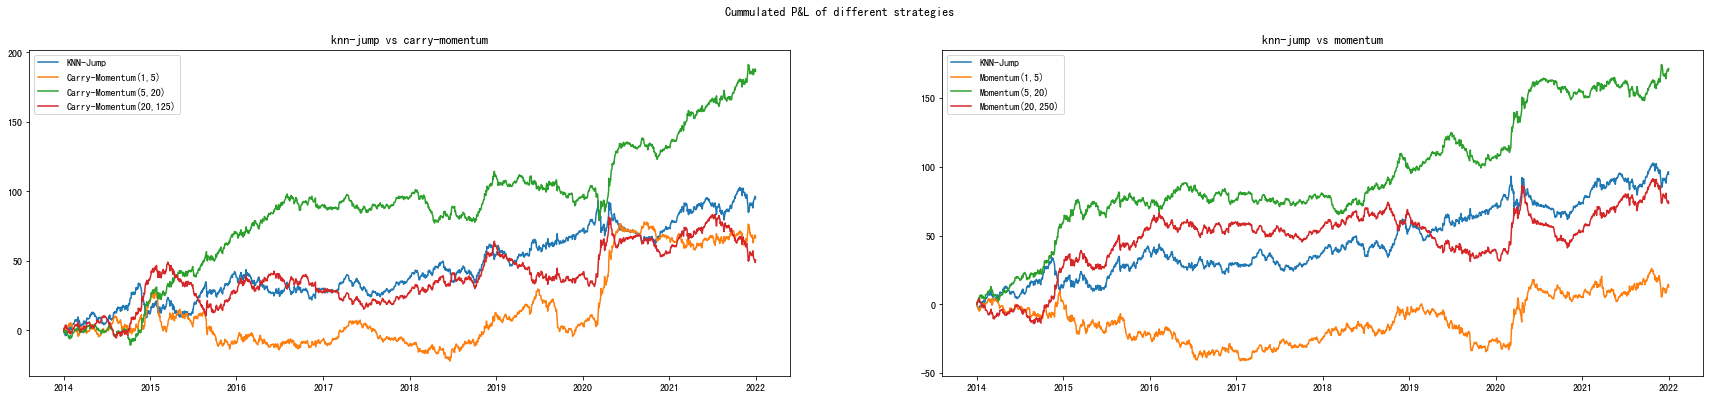

In [36]:
knn_carry_list = [knn_jump_result,carry_mom_1_5_result,carry_mom_5_20_result,carry_mom_20_125_result]
knn_mom_list  = [knn_jump_result, mom_1_5_result, mom_5_20_result, mom_20_250_result]
plt.figure(figsize=(30,6))
plt.suptitle('Cummulated P&L of different strategies')
plt.subplot(1,2,1)
for res in knn_carry_list:
    plt.plot(res.index, res['Cummulated P&L'])
plt.legend(['KNN-Jump','Carry-Momentum(1,5)','Carry-Momentum(5,20)','Carry-Momentum(20,125)'])
plt.title('knn-jump vs carry-momentum')

plt.subplot(1,2,2)
for res in knn_mom_list:
    plt.plot(res.index, res['Cummulated P&L'])
plt.legend(['KNN-Jump','Momentum(1,5)','Momentum(5,20)','Momentum(20,250)'])
plt.title('knn-jump vs momentum')

Tuning parameters for knn-jump

In [37]:
from TradingTools.knn_jump import *

original states(ordered by mom_20_250 signal) is: [0, 1, 2]
The meaningful states should be: [-1, 0, 1]
{0: -1, 1: 0, 2: 1}
original states(ordered by mom_20_250 signal) is: [1, 2, 0]
The meaningful states should be: [-1, 0, 1]
{1: -1, 2: 0, 0: 1}
original states(ordered by mom_20_250 signal) is: [1, 2, 0]
The meaningful states should be: [-1, 0, 1]
{1: -1, 2: 0, 0: 1}
original states(ordered by mom_20_250 signal) is: [2, 0, 1]
The meaningful states should be: [-1, 0, 1]
{2: -1, 0: 0, 1: 1}
original states(ordered by mom_20_250 signal) is: [2, 1, 0]
The meaningful states should be: [-1, 0, 1]
{2: -1, 1: 0, 0: 1}
original states(ordered by mom_20_250 signal) is: [1, 0, 2]
The meaningful states should be: [-1, 0, 1]
{1: -1, 0: 0, 2: 1}


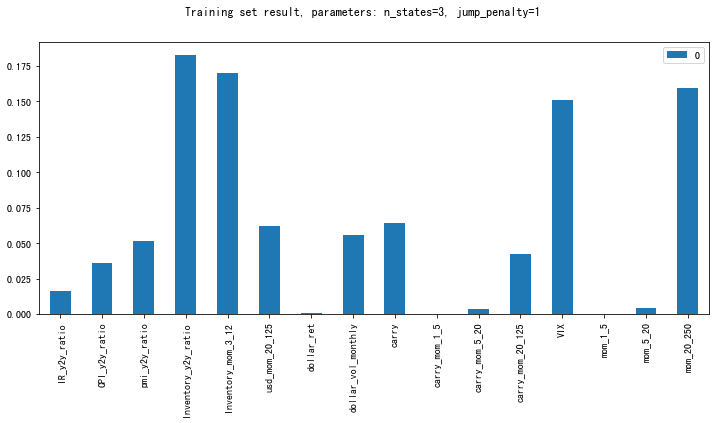

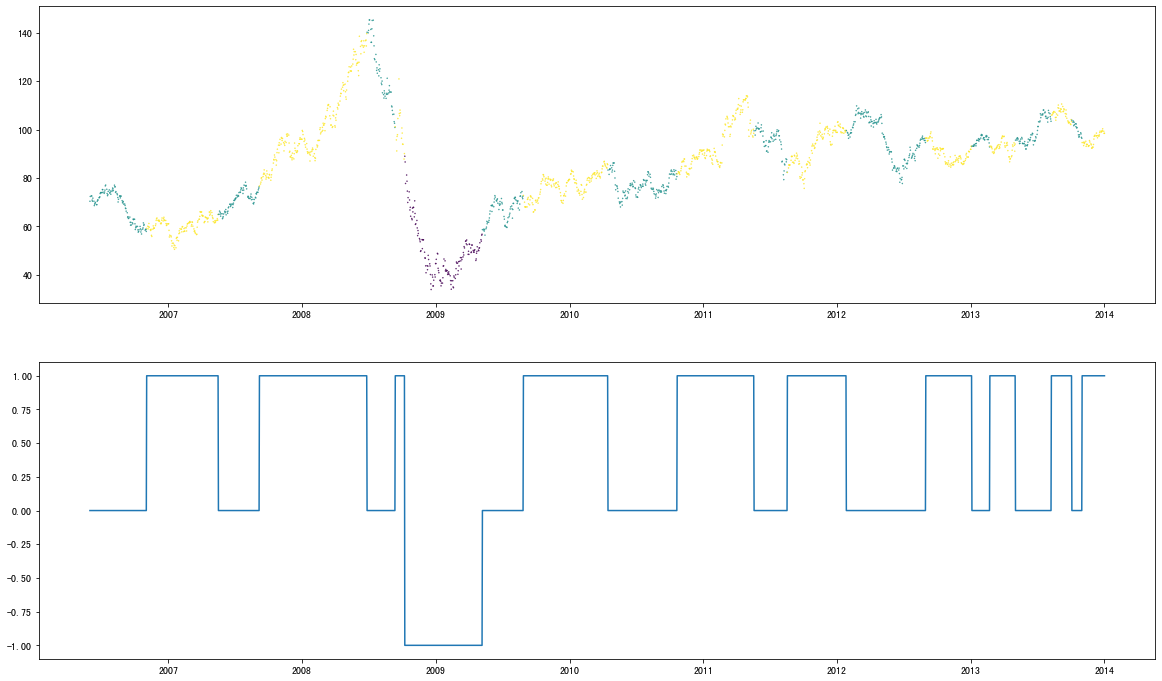

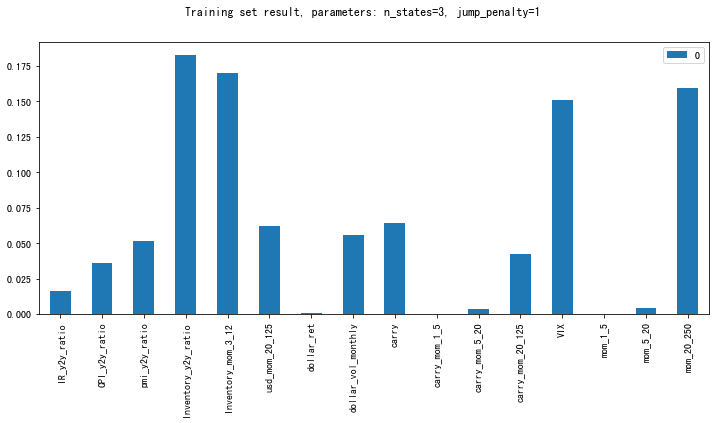

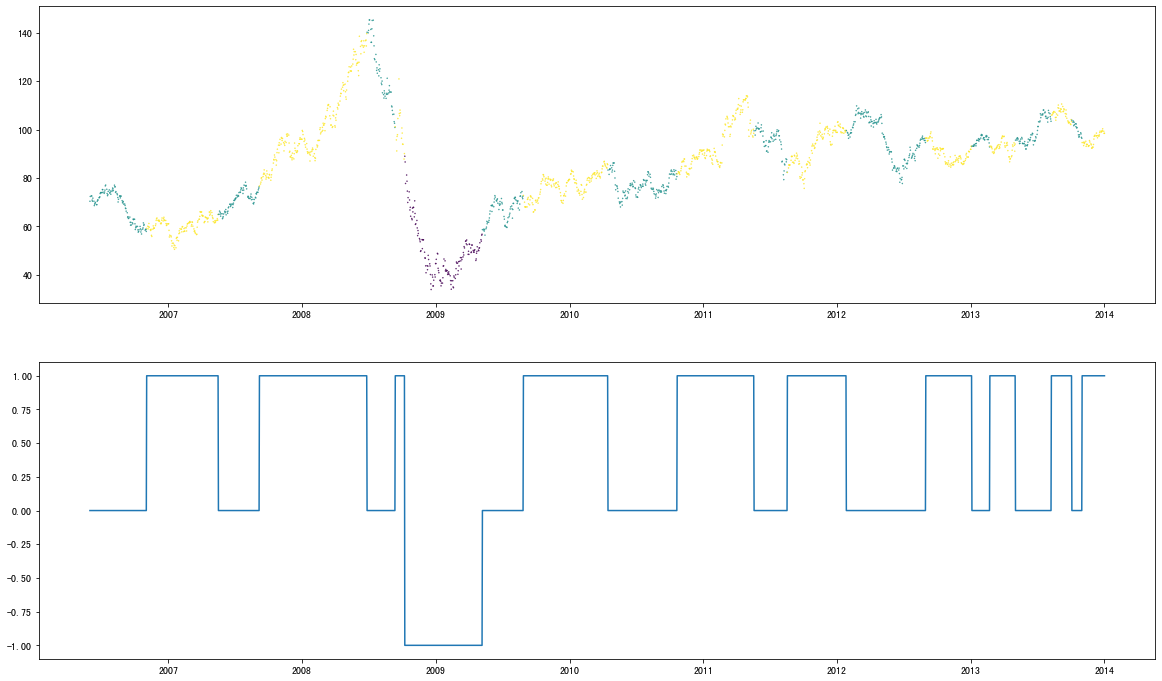

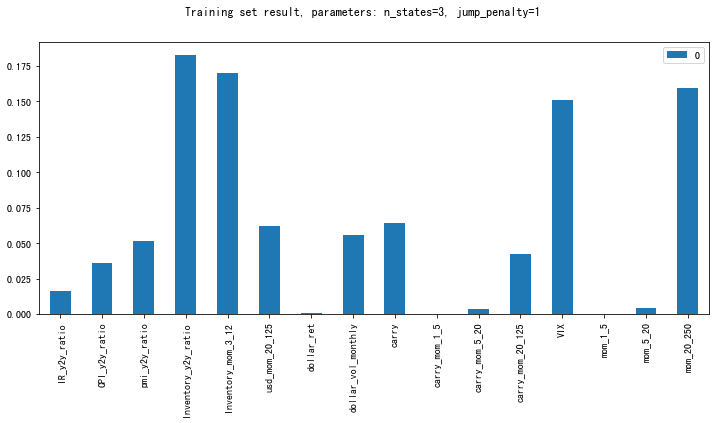

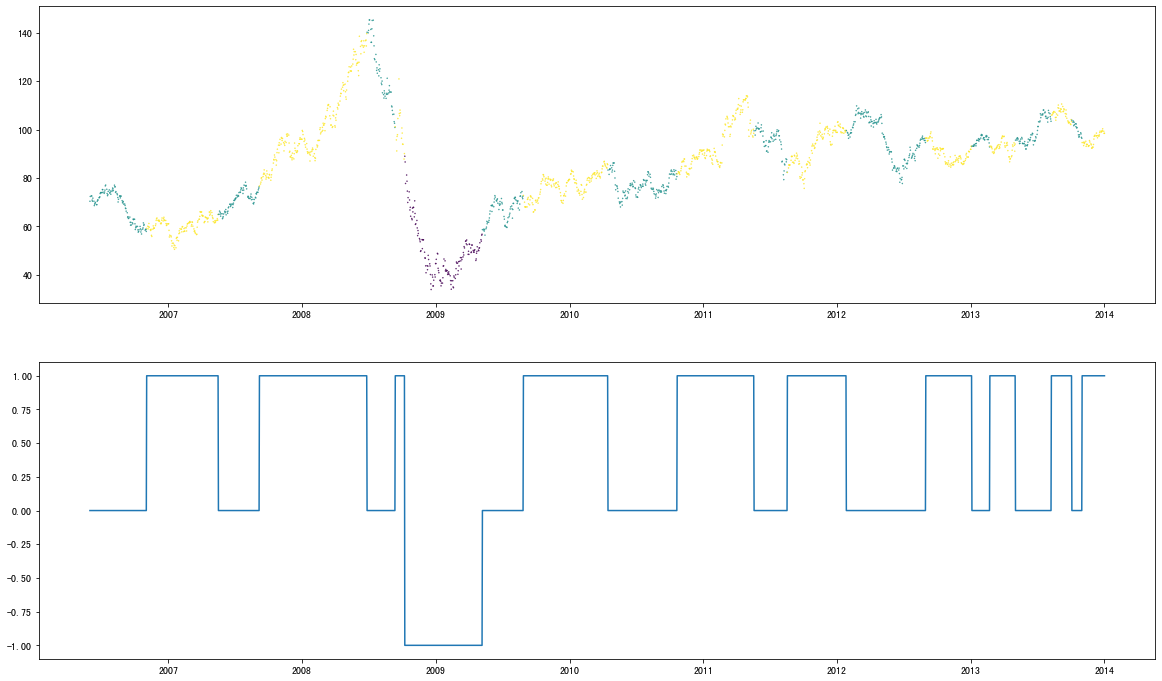

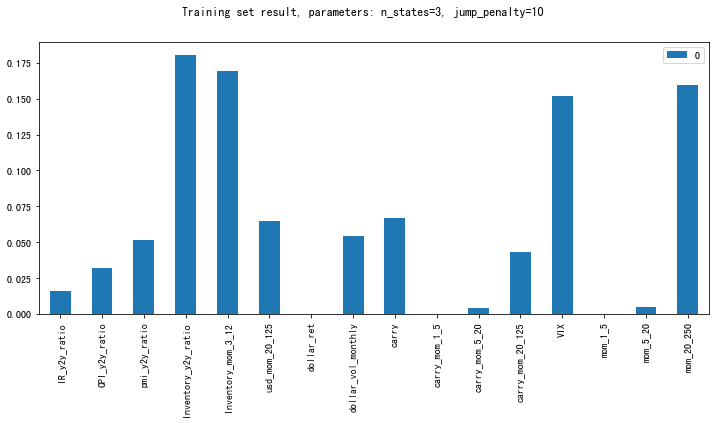

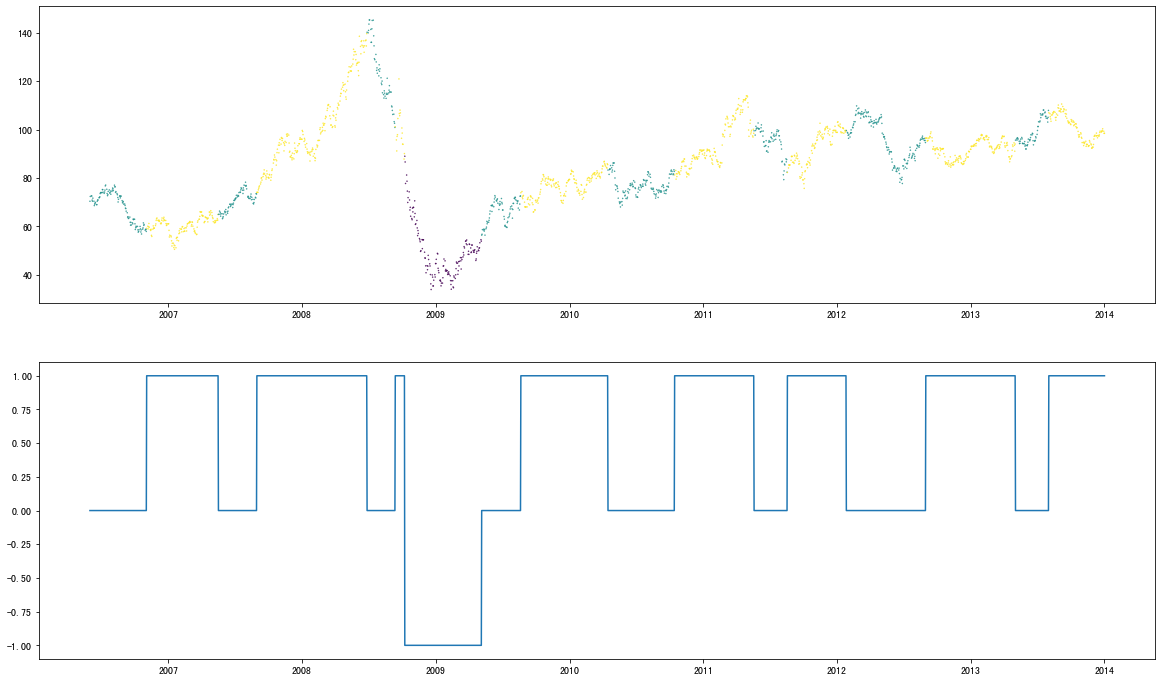

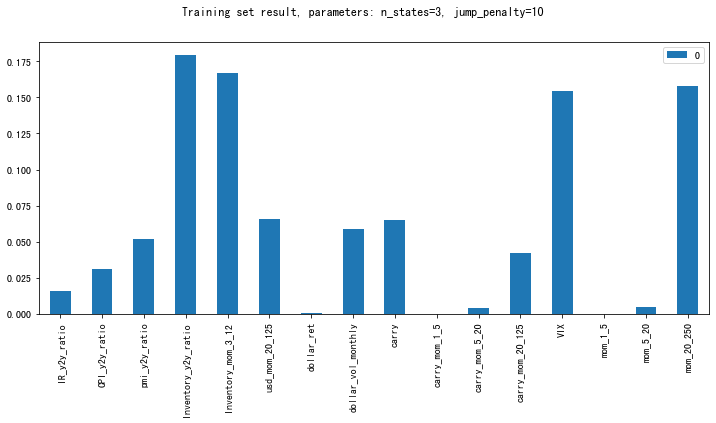

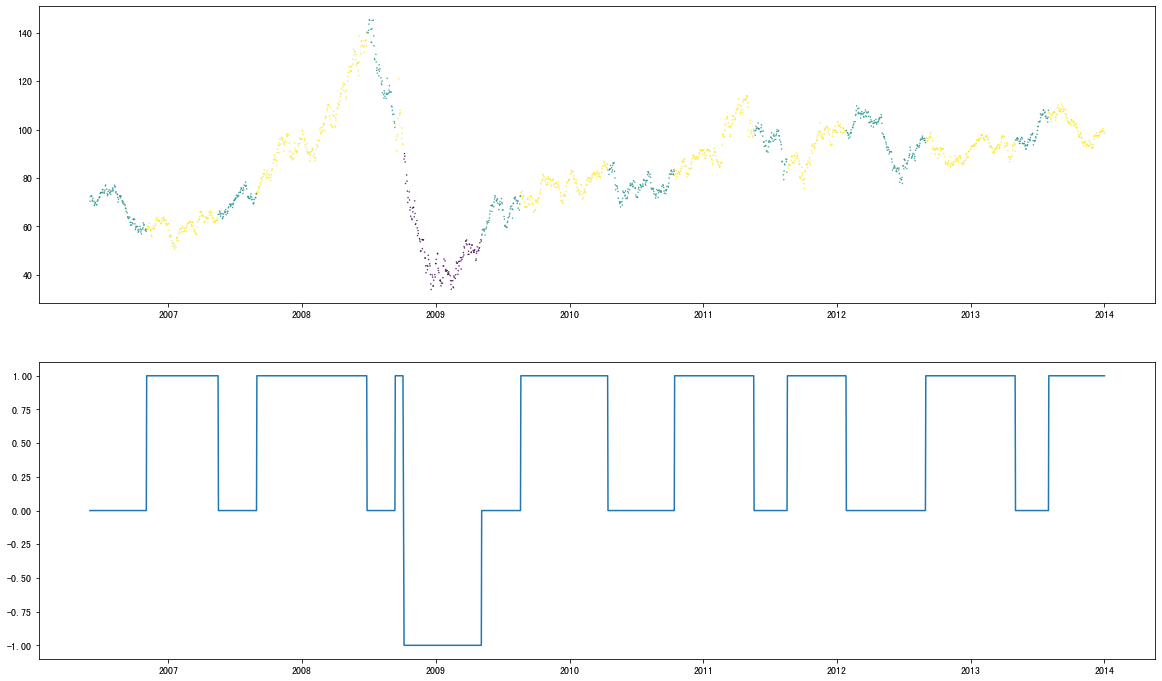

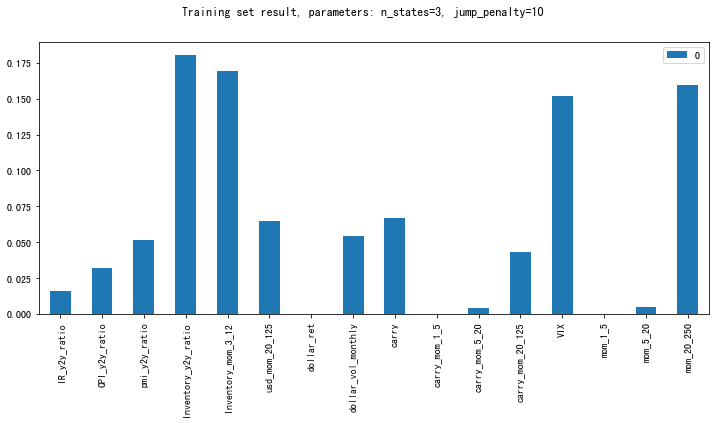

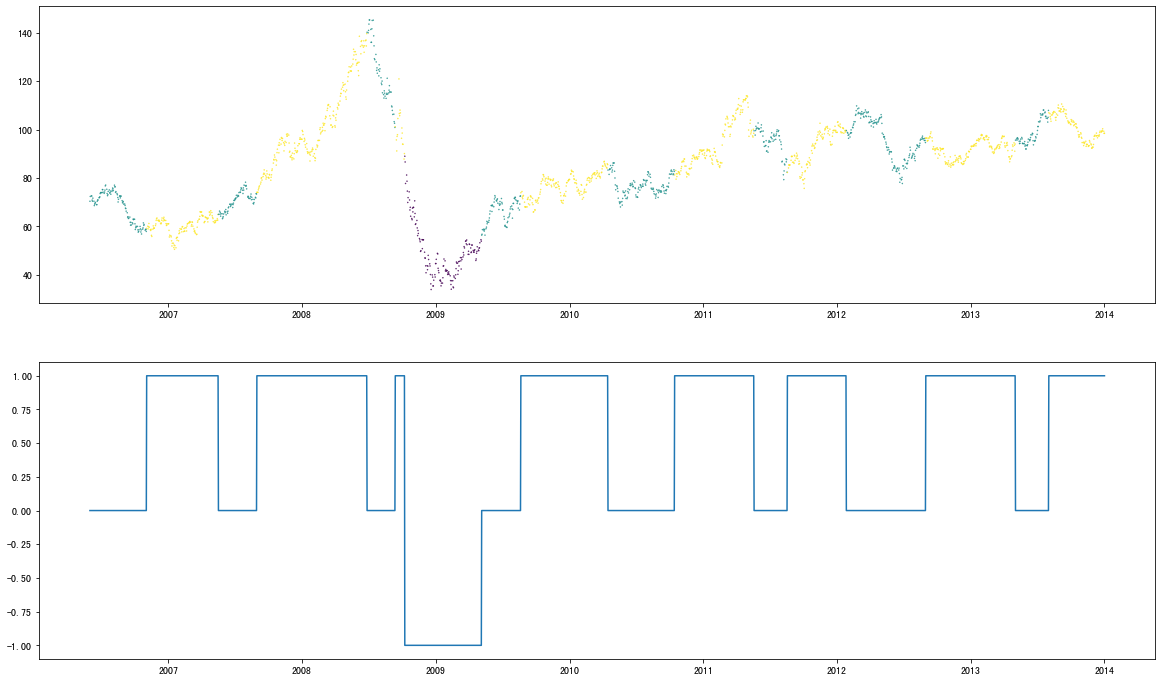

In [38]:
model_3_1_10 = knn_jump(n_states=3, jump_penalty=1, n_neighbors=10)
model_3_1_20 = knn_jump(n_states=3, jump_penalty=1, n_neighbors=20)
model_3_1_50 = knn_jump(n_states=3, jump_penalty=1, n_neighbors=50)

model_3_10_10 = knn_jump(n_states=3, jump_penalty=10, n_neighbors=10)
model_3_10_20 = knn_jump(n_states=3, jump_penalty=10, n_neighbors=20)
model_3_10_50 = knn_jump(n_states=3, jump_penalty=10, n_neighbors=50)

In [40]:
model_res_list = [model_3_1_10, model_3_1_20, model_3_1_50,
                    model_3_10_10, model_3_10_20, model_3_10_50]
                    
for _res in model_res_list:
    _res['signal'] = _res['signal'].apply(lambda x: 1 if x>0 else -1)

backtest_res_list_knn_jump = [trading_strategy_backtest(i['daily_PL'],i['signal']) for i in model_res_list]

In [42]:
Ann_PL = ['Annualized P&L']
SR = ['Sharpe Ratio']
MDD = ['Maximum Drawdown']
headers = ['Stat','knn-jump(3,1,10)','knn-jump(3,1,20)','knn-jump(3,1,50)',
            'knn-jump(3,10,10)','knn-jump(3,10,20)','knn-jump(3,10,50)']

for res in backtest_res_list_knn_jump:
    summary_res = calculate_summary_stats(res)
    Ann_PL.append(summary_res[0])
    SR.append(summary_res[1])
    MDD.append(summary_res[2])
print(tb([Ann_PL,SR,MDD], tablefmt='fancy_grid',headers=headers,numalign='center'))

╒══════════════════╤════════════════════╤════════════════════╤════════════════════╤═════════════════════╤═════════════════════╤═════════════════════╕
│ Stat             │  knn-jump(3,1,10)  │  knn-jump(3,1,20)  │  knn-jump(3,1,50)  │  knn-jump(3,10,10)  │  knn-jump(3,10,20)  │  knn-jump(3,10,50)  │
╞══════════════════╪════════════════════╪════════════════════╪════════════════════╪═════════════════════╪═════════════════════╪═════════════════════╡
│ Annualized P&L   │    2.09988e+06     │    1.17531e+06     │    1.22122e+06     │     1.57804e+06     │       905087        │       982754        │
├──────────────────┼────────────────────┼────────────────────┼────────────────────┼─────────────────────┼─────────────────────┼─────────────────────┤
│ Sharpe Ratio     │      1.03903       │      0.580612      │      0.603317      │      0.780016       │       0.44701       │      0.485381       │
├──────────────────┼────────────────────┼────────────────────┼────────────────────┼─────────────────

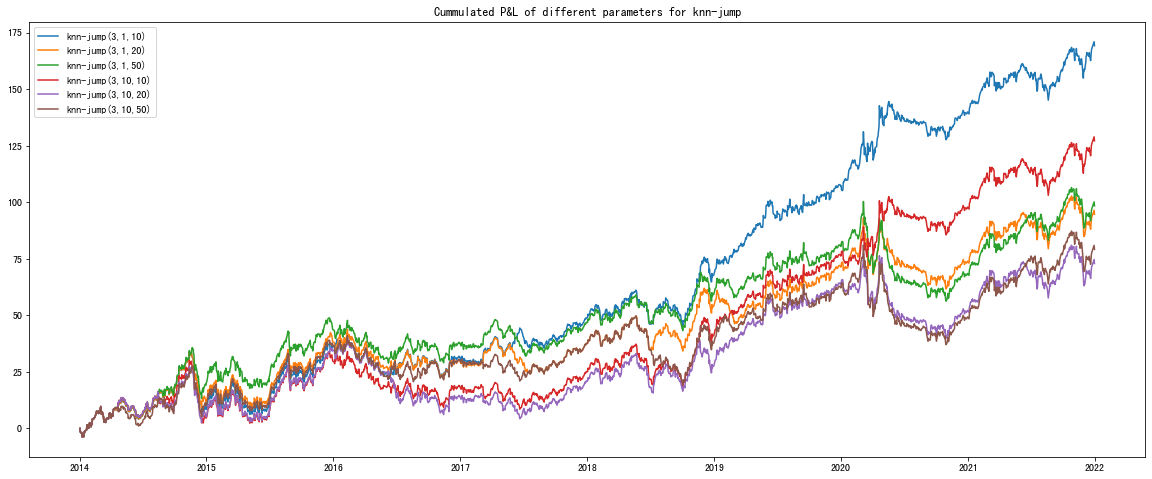

In [44]:
plt.figure(figsize=(20,8))
plt.title('Cummulated P&L of different parameters for knn-jump(n_states, jump_penalty, n_neighbors)')
for res in backtest_res_list_knn_jump:
    plt.plot(res.index, res['Cummulated P&L'])
plt.legend(['knn-jump(3,1,10)','knn-jump(3,1,20)','knn-jump(3,1,50)',
            'knn-jump(3,10,10)','knn-jump(3,10,20)','knn-jump(3,10,50)'])

We can see that the when penalty is lower, and the n_neighbors is smaller, the strategy's cummulated return and Sharpe retio are higher